# Setup env and load data

This is a test project to try different computer vision models (CNN from the scratch, transfer learning etc.). As the test dataset it uses CIFAR-10:
https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


## Paths

In [2]:
from pathlib import Path
import json

path_to_google_drive_dir = Path("drive/MyDrive/ML-practice/computer-vision")

In [3]:
def get_path(model_name: str) -> Path:
  """
  Get path to the dir/file and
  generate the parent dir if it doesn't exist.
  """
  path_to_model = path_to_google_drive_dir / model_name
  path_to_model.parent.mkdir(parents=True, exist_ok=True)
  return path_to_model

## Dataset

In [4]:
# Import dataset
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [5]:
y_train[0]

array([6], dtype=uint8)

In [6]:
# CIFAR-10 class names
class_names = [
    'airplane',   # 0
    'automobile', # 1
    'bird',       # 2
    'cat',        # 3
    'deer',       # 4
    'dog',        # 5
    'frog',       # 6
    'horse',      # 7
    'ship',       # 8
    'truck',      # 9
  ]

# Data preprocessing

In [7]:
def show_images(images: np.ndarray,
                labels: np.ndarray,
                class_names: list[str] = class_names,
                n: int = 5) -> None:
    """
    Display a row of images with their class labels.

    Args:
        images (np.array): image data (e.g., X_train)
        labels (np.array): integer labels (e.g., y_train)
        class_names (list): class name list for decoding
        n (int): number of images to show
    """
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        label_index = labels[i] if labels.ndim == 1 else labels[i][0]
        plt.title(class_names[label_index])
        plt.axis('off')
    plt.show()

In [8]:
# show_images(X_train, y_train, n=5)

In [9]:
from tensorflow.keras.utils import to_categorical

# Normalize pixel values
X_train, X_test = X_train / 255.0, X_test / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

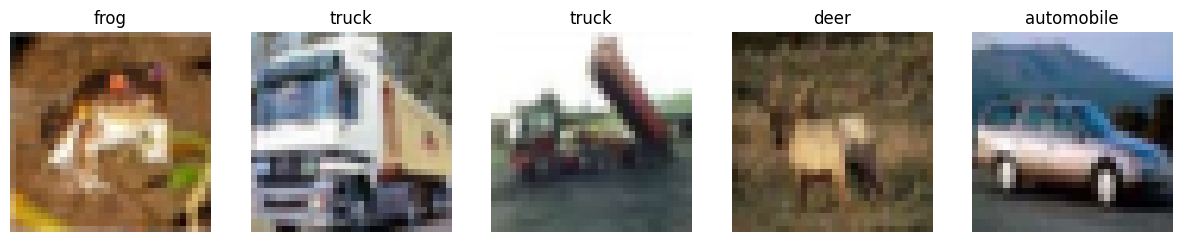

In [10]:
show_images(X_train, y_train, n=5)

# Evaluation functions

In [11]:
# Histories dict to collect and compare the metrics
histories = {}

In [12]:
def plot_confusion_matrix(model: tf.keras.Model,
                          X_test: np.ndarray,
                          y_test: np.ndarray,
                          y_pred: np.ndarray,
                          y_true: np.ndarray) -> None:
    """
    Plot the confusion matrix of a model.
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix for model: " + model.name)
    plt.show()

In [13]:
def plot_training_histories(histories: dict[str, tf.keras.callbacks.History],
                            metric: str = 'accuracy') -> None:
    plt.figure(figsize=(10, 5))
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} Train')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} Val')
    plt.title(f'{metric.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. CNN from scratch

## 1.1. Simple default CNN

### Build a model

#### Get model

In [14]:
from tensorflow.keras.models import Model

def create_model_1_scratch_cnn(input_shape=(32, 32, 3), num_classes=10) -> Model:
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### Train model
Or load the existing saved model.

In [15]:
from typing import Callable, Union
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

def load_or_train_model(create_fn: Callable[[], Model],
                        model_path: Path,
                        history_path: Path,
                        datagen: ImageDataGenerator,
                        callbacks: list[Callback],
                        X_train: tf.Tensor,
                        y_train_cat: tf.Tensor,
                        X_test: tf.Tensor,
                        y_test_cat: tf.Tensor,
                        epochs: int = 30) -> tuple[Model, History]:
    """
    Load a saved model or train a new one and save it.

    Args:
        create_fn: function that returns a compiled Keras model.
        model_path: path to the saved model (.keras or .h5).
        datagen: an ImageDataGenerator for data augmentation.
        callbacks: list of Keras callbacks (e.g., EarlyStopping, ModelCheckpoint).
        X_train, y_train_cat: training data (augmented using datagen).
        X_test, y_test_cat: validation data.
        epochs: number of training epochs.

    Returns:
        A trained or loaded Keras model.
    """
    try:
        model = load_model(model_path)
        print(f"✅ Loaded saved model from {model_path}")

        history = json.load(open(history_path))
        print(f"✅ Loaded history from {history_path}")

    except Exception as e:
        print(f"⚠️ Could not load model or history: {e}")
        model = create_fn()

        datagen.fit(X_train)

        history: History = model.fit(
            datagen.flow(X_train, y_train_cat, batch_size=64),
            validation_data=(X_test, y_test_cat),
            epochs=epochs,
            callbacks=callbacks
        )

        model.save(model_path)
        print(f"💾 Model is saved to {model_path}")

        history_path.write_text(json.dumps(history.history))
        print(f"💾 History is saved to {history_path}")

    return model, history


#### Data augmentation

In [16]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
def create_datagen(rotation_range: int = 15,
                    horizontal_flip: bool = True,
                    width_shift_range: float = 0.1,
                    height_shift_range: float = 0.1) -> ImageDataGenerator:
    return ImageDataGenerator(
        rotation_range=rotation_range,
        horizontal_flip=horizontal_flip,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range
    )


### Training

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths
path_to_model_1_scratch_cnn = get_path("model_1_scratch_cnn.keras")
path_to_model_1_scratch_cnn_history = get_path("model_1_scratch_cnn_history.json")

# Train (load) model
model_1_scratch_cnn, history_1_scratch_cnn = load_or_train_model(
    create_fn=create_model_1_scratch_cnn,
    model_path=path_to_model_1_scratch_cnn,
    history_path=path_to_model_1_scratch_cnn_history,
    datagen=create_datagen(),
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("best_model.keras", save_best_only=True)
    ],
    X_train=X_train,
    y_train_cat=y_train_cat,
    X_test=X_test,
    y_test_cat=y_test_cat
)

# Save history
histories[model_1_scratch_cnn.name] = history_1_scratch_cnn

⚠️ Could not load model or history: File not found: filepath=drive/MyDrive/ML-practice/computer-vision/model_1_scratch_cnn.keras. Please ensure the file is an accessible `.keras` zip file.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.3056 - loss: 1.8902 - val_accuracy: 0.4900 - val_loss: 1.4196
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.4972 - loss: 1.4047 - val_accuracy: 0.5858 - val_loss: 1.1978
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.5506 - loss: 1.2725 - val_accuracy: 0.6248 - val_loss: 1.0831
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.5794 - loss: 1.1973 - val_accuracy: 0.6337 - val_loss: 1.0467
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.5957 - loss: 1.1464 - val_accuracy: 0.6377 - val_loss: 1.0360
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6081 - loss: 1.1070 - val_accuracy: 0.6372 - val_loss: 1.0392
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6181 - loss: 1.0806 - val_accuracy: 0.6476 - val_loss: 1.0378
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.6304 - loss: 1.0531 - val_accurac

### Evaluation

In [18]:
model_1_scratch_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,688 (1.92 MB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 335,126 (1.28 MB)

In [19]:
y_pred = np.argmax(model_1_scratch_cnn.predict(X_test), axis=1)
y_true = y_test.flatten()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1000
           1       0.78      0.91      0.84      1000
           2       0.66      0.61      0.63      1000
           3       0.69      0.43      0.53      1000
           4       0.68      0.69      0.69      1000
           5       0.69      0.60      0.64      1000
           6       0.69      0.87      0.77      1000
           7       0.68      0.83      0.75      1000
           8       0.85      0.82      0.83      1000
           9       0.81      0.82      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



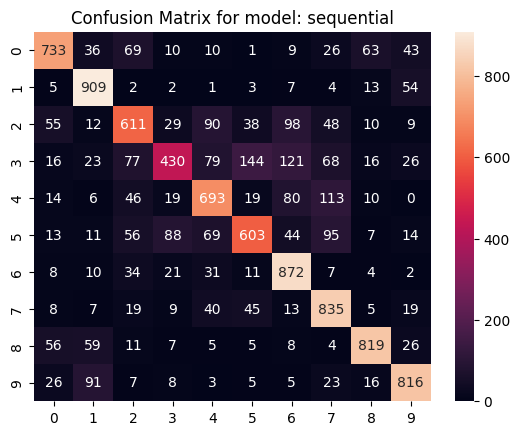

In [21]:
plot_confusion_matrix(model_1_scratch_cnn,
                      X_test=X_test,
                      y_test=y_test,
                      y_pred=y_pred,
                      y_true=y_true)